# Resistance Measurements of 2nd Batch of Sponge-Wedge Chips

## Summary Graphs

### Data
Electrical resistances from a total of n=3 chips were measured. 

Data are organized in dictionaries of repeated measurements of averages and standard deviations of 100 observations for each channel (using the Keithley Multimeter device). Each value is the average and the standard deviation of the 100 observations. Keys of the dictionary are protocols, and value is the data (which is a dictionary, too). The data dictionary is 

In [1]:
data_csv_filename = '2nd_batch_resistances_py.xlsx'

In [2]:
def _get_src_dir() -> str:
    return os.path.split(os.path.dirname(os.path.abspath('__file__')))[0]

In [3]:
import os
os.chdir(_get_src_dir())
from src.utility import _Utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
data_path = os.path.join(_Utility.get_user_data_dir_path(), data_csv_filename)

In [5]:
print(data_path)

/home/mkrause/data/biofuel-cell/2nd_batch_resistances_py.xlsx


In [6]:
sheet_names = [
    'protocol01_positive_control', 
    'protocol02_positive_control', 
    'protocol03_positive_control']
# for sheet_name in sheet_names:
df = pd.read_excel(data_path, sheet_name=sheet_names[0])

In [7]:
df.head()

,R_avg [Ohm],R_stdev [Ohm],fraction of R_stdev,chip_id
0,3190,0.128,0.000040,1
1,42900000,73100.000,0.001704,1
2,3920,3.000,0.000765,1
3,40370000,172000.000,0.004261,1
4,95400000,700000.000,0.007338,1


Read all sheets of the Excel file

In [8]:
xlsx = pd.read_excel(data_path, sheet_name=None)
print(xlsx.keys())

dict_keys(['protocol01_positive_control', 'protocol01_negative_control', 'protocol02_positive_control', 'protocol02_negative_control', 'protocol03_positive_control', 'protocol03_negative_control'])


Add a 'Sheet' column to each dataframe

In [9]:
for sheet_name in xlsx.keys():
    xlsx[sheet_name]['Sheet'] = sheet_name

Concatenate sheets of positive controls into one DataFrame

In [10]:
df = pd.concat(xlsx[frame] for frame in xlsx.keys() if 'positive' in frame)

In [11]:
df.head()

,R_avg [Ohm],R_stdev [Ohm],fraction of R_stdev,chip_id,Sheet
0,3190,0.128,0.000040,1,protocol01_positive_control
1,42900000,73100.000,0.001704,1,protocol01_positive_control
2,3920,3.000,0.000765,1,protocol01_positive_control
3,40370000,172000.000,0.004261,1,protocol01_positive_control
4,95400000,700000.000,0.007338,1,protocol01_positive_control


In [12]:
print(df)

   R_avg [Ohm]  R_stdev [Ohm]  fraction of R_stdev  chip_id  \
0         3190          0.128             0.000040        1   
1     42900000      73100.000             0.001704        1   
2         3920          3.000             0.000765        1   
3     40370000     172000.000             0.004261        1   
4     95400000     700000.000             0.007338        1   
5         3530         10.500             0.002975        1   
6         4040         24.700             0.006114        1   
7         3000         11.000             0.003667        1   
8         4150         56.000             0.013494        1   
0         5400         51.000             0.009444        2   
1        30000         71.000             0.002367        2   
2        39000        156.000             0.004000        2   
3      1240000      32000.000             0.025806        2   
4       212000        417.000             0.001967        2   
5        38000         53.000             0.001395     

## Plot all data

### Plot each average of a 100 samples with its corresponding standard deviation.

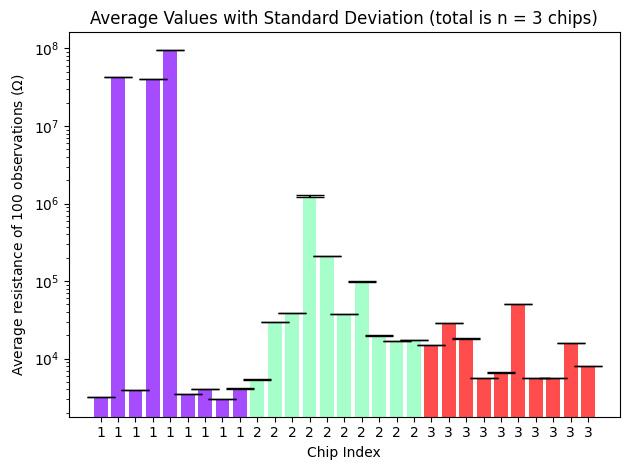

In [41]:
# Get the data and errors from the DataFrame.
averages = df['R_avg [Ohm]']
std_devs = df['R_stdev [Ohm]']

# Create an array with the positions of each bar on the x-axis.
x_pos = np.arange(len(averages))

# 'chip_id' is the column with group ids.
chip_ids: np.ndarray = df['chip_id'].unique()

# Create a color dictionary for unique groups.
colors: dict = {chip_id: plt.cm.rainbow(np.linspace(0, 1, len(chip_ids))[i]) for i, chip_id in enumerate(chip_ids)}

# Create a bar plot with error bars.
# plt.bar(x_pos, averages, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

# Create a bar plot with error bars by plotting each individual bar, one at a time.
for i in range(len(df)):
    plt.bar(x_pos[i], averages.iloc[i], yerr=std_devs.iloc[i], align='center', alpha=0.7, ecolor='black', capsize=10,
           color=colors[df['chip_id'].iloc[i]])

# Set the y-axis to be logarithmic.
plt.yscale('log')


# Customize the plot.
plt.title('Average Values with Standard Deviation (total is n = 3 chips)')
plt.ylabel('Average resistance of 100 observations ($\Omega$)')
plt.xlabel('Chip Index')
plt.xticks(x_pos, df['chip_id'])
plt.tight_layout()

fig_filename = os.path.join(_Utility.get_user_data_dir_path(), 'resistances_2nd_batch.png')
plt.savefig(fig_filename)

# Display the plot.
plt.show()


### Create average of each chip

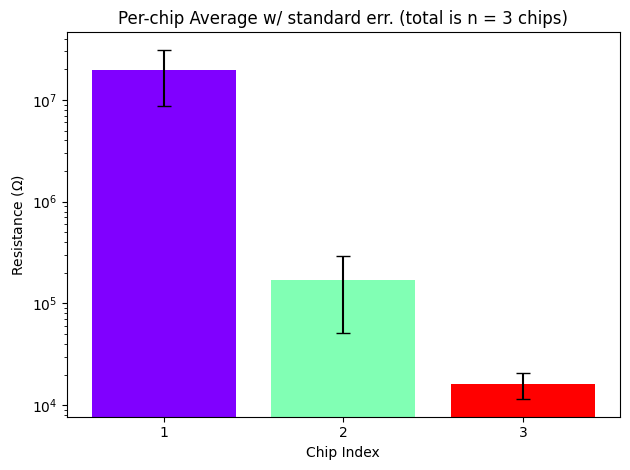

In [44]:
means = df.groupby('chip_id')['R_avg [Ohm]'].mean()
stderr = df.groupby('chip_id')['R_avg [Ohm]'].apply(stats.sem)
groups = means.index

# Create a color dictionary for unique groups.
colors: dict = {group: plt.cm.rainbow(np.linspace(0, 1, len(groups))[i]) for i, group in enumerate(groups)}

# Create a bar plot.
for i in range(len(groups)):
    plt.bar(i, means.iloc[i], yerr=stderr.iloc[i], color=colors[groups[i]], capsize=5)

# Set x-ticks to the group names.
plt.xticks(np.arange(len(groups)), groups)

# Set the y-axis to be logarithmic.
plt.yscale('log')


# Customize the plot.
plt.title('Per-chip Average w/ standard err. (total is n = 3 chips)')
plt.ylabel('Resistance ($\Omega$)')
plt.xlabel('Chip Index')
plt.tight_layout()

fig_filename = os.path.join(_Utility.get_user_data_dir_path(), 'resistances_2nd_batch_per_chip.png')
plt.savefig(fig_filename)

# Display the plot.
plt.show()

### Detecting (and removing) outliers

It could be that some the values in chip 1 are outliers, possibly because the channels the data originated from, were actually not conducting (something I didn't pay enough attention to when I did the measurement). This is a way to detect outliers: a value is considered an outlier if it is not within the range of the first and third quartile.

In [37]:
def remove_outliers(group: pd.core.series.Series) -> pd.core.series.Series:
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (group < (Q1 - 1.5 * IQR)) | (group > (Q3 + 1.5 * IQR))
    if any(outliers):
        print(f'Found {outliers.sum()} outliers in chip {group.name}!')
    return group[~outliers]

In [38]:
df_without_outliers = df.groupby('chip_id')['R_avg [Ohm]'].apply(remove_outliers).reset_index()

Found 2 outliers in chip 2!
Found 1 outliers in chip 3!


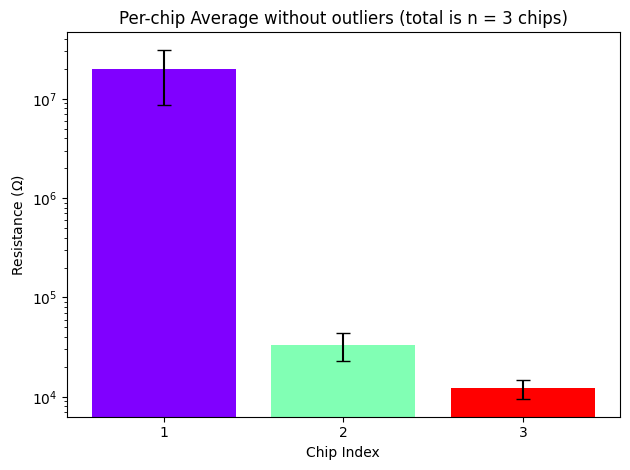

In [43]:
means = df_without_outliers.groupby('chip_id')['R_avg [Ohm]'].mean()
stderr = df_without_outliers.groupby('chip_id')['R_avg [Ohm]'].apply(stats.sem)
# Create a color dictionary for unique groups.
colors: dict = {group: plt.cm.rainbow(np.linspace(0, 1, len(groups))[i]) for i, group in enumerate(groups)}

# Create a bar plot.
for i in range(len(groups)):
    plt.bar(i, means.iloc[i], yerr=stderr.iloc[i], color=colors[groups[i]], capsize=5)

# Set x-ticks to the group names.
plt.xticks(np.arange(len(groups)), groups)

# Set the y-axis to be logarithmic.
plt.yscale('log')


# Customize the plot.
plt.title('Per-chip Average without outliers (total is n = 3 chips)')
plt.ylabel('Resistance ($\Omega$)')
plt.xlabel('Chip Index')
plt.tight_layout()

fig_filename = os.path.join(_Utility.get_user_data_dir_path(), 'resistances_2nd_batch_per_chip_no_outliers.png')
plt.savefig(fig_filename)

# Display the plot.
plt.show()